In [ ]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from poker_embeddings.models.card import HandGNN, HandClassifier
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from poker_embeddings.poker_utils.constants import DECK_DICT
import matplotlib.pyplot as plt
from poker_embeddings.poker_utils.hands import create_deck_graph, query_subgraph
from poker_embeddings.poker_utils.hands import _card_to_idx
from torch_geometric.data import Data, Batch

In [2]:
loss_data = []
for path in glob.glob("../training_results/hand_rank_model/**/*train_loss*", recursive=True):
    dat = pd.read_csv(path)
    loss_data.append(dat)
loss_data = pd.concat(loss_data)

<Axes: xlabel='epochs', ylabel='train_accuracy'>

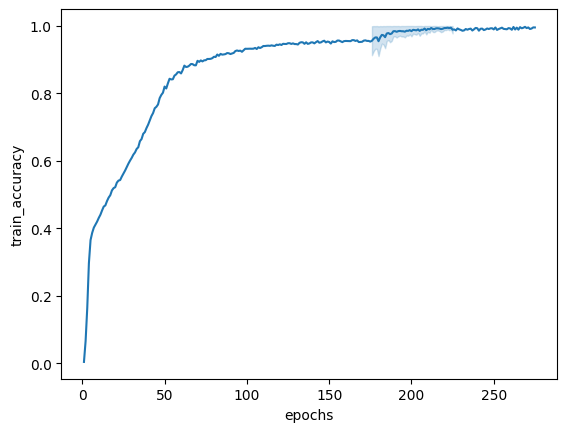

In [3]:
sns.lineplot(data=loss_data, x='epochs',y='train_accuracy')

In [4]:
report = pd.read_csv("../training_results/hand_rank_model/run4/hand_rank_predictor_classification_report_225.csv")
cm = pd.read_csv("../training_results/hand_rank_model/run4/hand_rank_predictor_confusion_matrix_225.csv")

In [5]:
print(report)

         Unnamed: 0  precision    recall  f1-score        support
0           nothing   1.000000  0.999477  0.999739  359591.000000
1          one_pair   1.000000  0.999957  0.999979  303168.000000
2          two_pair   1.000000  1.000000  1.000000   34180.000000
3   three_of_a_kind   1.000000  0.999934  0.999967   15144.000000
4          straight   0.935170  1.000000  0.966499    2784.000000
5             flush   0.993754  0.997909  0.995828    1435.000000
6        full_house   0.999022  1.000000  0.999511    1022.000000
7    four_of_a_kind   1.000000  1.000000  1.000000     165.000000
8    straight_flush   0.550000  0.916667  0.687500      12.000000
9       royal_flush   0.000000  0.000000  0.000000       6.000000
10         accuracy   0.999705  0.999705  0.999705       0.999705
11        macro avg   0.847795  0.891394  0.864902  717507.000000
12     weighted avg   0.999719  0.999705  0.999707  717507.000000


In [6]:
cm

,Unnamed: 0,class,High Card,Pair,Two Pair,Three of a Kind,Straight,Flush,Full House,Four of a Kind,Straight Flush,Royal Flush
0,0,High Card,359403,0,0,0,180,8,0,0,0,0
1,1,Pair,0,303155,0,0,13,0,0,0,0,0
2,2,Two Pair,0,0,34180,0,0,0,0,0,0,0
3,3,Three of a Kind,0,0,0,15143,0,0,1,0,0,0
4,4,Straight,0,0,0,0,2784,0,0,0,0,0
5,5,Flush,0,0,0,0,0,1432,0,0,3,0
6,6,Full House,0,0,0,0,0,0,1022,0,0,0
7,7,Four of a Kind,0,0,0,0,0,0,0,165,0,0
8,8,Straight Flush,0,0,0,0,0,1,0,0,11,0
9,9,Royal Flush,0,0,0,0,0,0,0,0,6,0


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = HandClassifier().to(device)
model.load_state_dict(torch.load("../model_weights/hand_rank_model/hand_rank_predictor225.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
# with torch.no_grad():
#     card_embeddings = model.hand_encoder.card_embedder.weight
#     card_embeddings = model.hand_encoder.card_emb_projector(card_embeddings).cpu()
#     card_embeddings_norm = F.normalize(card_embeddings, p=2, dim=1).numpy()

In [ ]:
# tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=29)
# emb_2d = tsne.fit_transform(card_embeddings_norm)

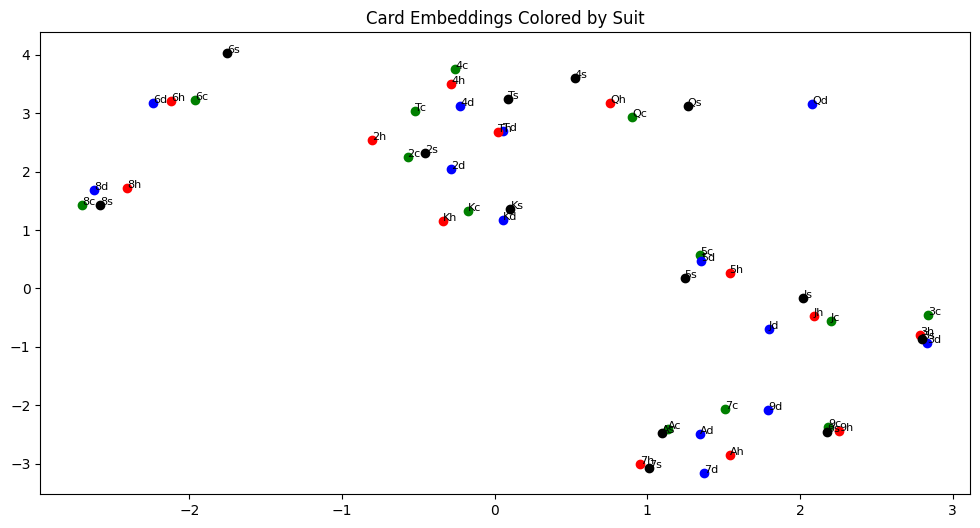

In [ ]:

# suit_colors = {
#     0: 'green', # Clubs
#     1: 'blue', # Diamonds
#     2: 'red', # Hearts
#     3: 'black' # Spades
# }
# colors = [suit_colors[i % 4] for i in range(len(DECK_DICT))]

# plt.figure(figsize=(12, 6))
# for i, txt in DECK_DICT.items():
#     if i == 52:
#         continue
#     plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=suit_colors[i % 4])
#     plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

# plt.title("Card Embeddings Colored by Suit")
# plt.show()

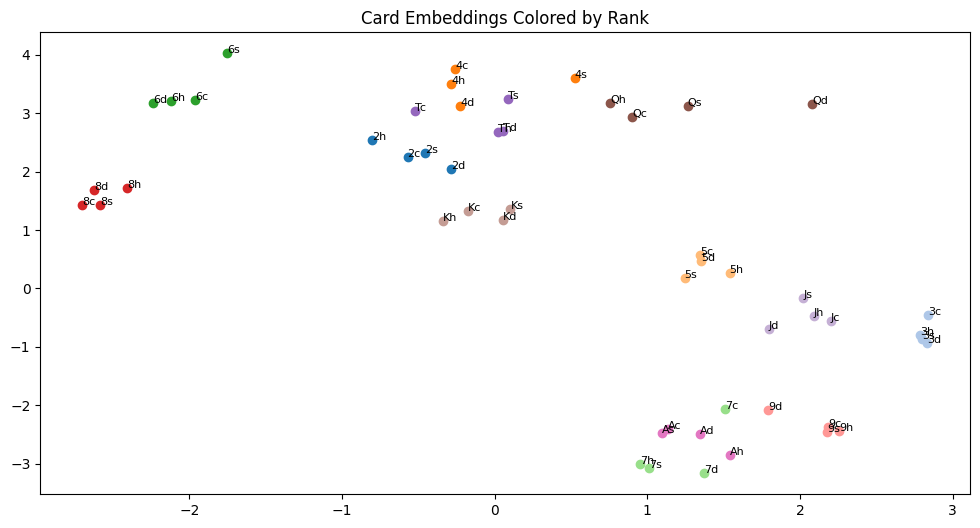

In [ ]:
# rank_colors = plt.colormaps.get_cmap('tab20')
# colors = [rank_colors(i // 4) for i in range(len(DECK_DICT))]
# plt.figure(figsize=(12, 6))
# for i, txt in DECK_DICT.items():
#     if i == 52:
#         continue
#     plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=rank_colors(i // 4))
#     plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

# plt.title("Card Embeddings Colored by Rank")
# plt.show()

In [30]:
deck_graph_edge_index, deck_graph_edge_attr = create_deck_graph()

In [10]:
def predict(hands, model, return_logits=True):
    class_names = [
        "high_card", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    deck_graph_edge_index, deck_graph_edge_attr = create_deck_graph()
    if isinstance(hands, torch.Tensor):
        if hands.dim() == 1:
            hand_edge_index, hand_edge_attr = query_subgraph(hands, deck_graph_edge_index, deck_graph_edge_attr)
            graph = Data(x=hands, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
            graph = Batch.from_data_list([graph])
        else:
            graphs = []
            for hand in hands:
                hand_edge_index, hand_edge_attr = query_subgraph(hand, deck_graph_edge_index, deck_graph_edge_attr)
                graph = Data(x=hand, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
                graphs.append(graph)
            graph = Batch.from_data_list(graphs)

    elif isinstance(hands, list) and all(isinstance(hand, list) for hand in hands):
        graphs = []
        for hand in hands:
            if isinstance(hand[0], str):
                hand = torch.tensor([_card_to_idx[card] for card in hand])
            else:
                hand = torch.tensor(hand)
            hand_edge_index, hand_edge_attr = query_subgraph(hand, deck_graph_edge_index, deck_graph_edge_attr)
            graph = Data(x=hand, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
            graphs.append(graph)
        graph = Batch.from_data_list(graphs)
    elif isinstance(hands, list):
        hand = torch.tensor([_card_to_idx[card] for card in hands])
        hand_edge_index, hand_edge_attr = query_subgraph(hand, deck_graph_edge_index, deck_graph_edge_attr)
        graph = Data(x=hand, edge_index=hand_edge_index, edge_attr=hand_edge_attr)
        graph = Batch.from_data_list([graph])

    with torch.no_grad():
        logits = model(graph)
    if return_logits:
        return logits
    else:
        preds = logits.argmax(dim=1)
        return [class_names[i.item()] for i in preds]


In [11]:
class_names = [
        "high_card", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]

In [12]:
cards = [
    ['As','Ad','Tc','7c'],
    ['As','Ad','Tc','7c','Ac'],
    ['7h','8h','3s','Th',"Qh","Jh"],
    ['Th','Jh',"Qs","As","Kc"]
    ]
predict(cards, model, return_logits=False)

IndexError: too many indices for tensor of dimension 1

In [58]:
logits = predict([["Ks","Qc","Js","Qs","Jd","Qd"]], model, return_logits=True)
distribution = [i.item() for i in F.softmax(logits.squeeze(0), dim=0)]
pd.DataFrame({'rank': class_names,'pred_probs':distribution}).sort_values(by='pred_probs', ascending=False).round(4)

,rank,pred_probs
6,full_house,1.0
2,two_pair,0.0
3,three_of_a_kind,0.0
7,four_of_a_kind,0.0
8,straight_flush,0.0
5,flush,0.0
9,royal_flush,0.0
4,straight,0.0
1,one_pair,0.0
0,high_card,0.0


In [16]:
cards = [
    list(DECK_DICT.values())
    ]
logits = predict(cards, model, return_logits=True).squeeze(0)
distribution = [i.item() for i in F.softmax(logits, dim=0)]
pd.DataFrame({'rank': class_names,'pred_probs':distribution}).sort_values(by='pred_probs', ascending=False).round(4)

,rank,pred_probs
7,four_of_a_kind,1.0
0,high_card,0.0
1,one_pair,0.0
2,two_pair,0.0
4,straight,0.0
3,three_of_a_kind,0.0
5,flush,0.0
6,full_house,0.0
8,straight_flush,0.0
9,royal_flush,0.0
